**Prelude, Regular expresions**

In [1]:
import re
import numpy as np
import pandas as pd


In [4]:
dfdc_raw = pd.read_csv('../provided_csvs/dc.csv')
dfmarvel_raw = pd.read_csv('../provided_csvs/marvel.csv')


In [5]:
dfdc_row, dfdc_column = dfdc_raw.shape
dfmarvel_row, dfmarvel_column = dfmarvel_raw.shape

print(
    f'The imported data contains {dfdc_row} DC characters and {dfmarvel_row} marvel characters')

# Initial view of the data
dfdc_raw.head()
dfmarvel_raw.head()


The imported data contains 771 DC characters and 2373 marvel characters


,Unnamed: 0,CharacterName,WikiLink
0,0,Abomination,Abomination (character)
1,1,Absorbing Man,Absorbing Man
2,2,Abraxas,NaN
3,3,Abyss,NaN
4,4,Access,NaN


In [4]:
dfdc_raw = dfdc_raw.replace(r'^\s+$', np.nan, regex=True)
print(f'The following NaN/empty fields in the DC dataset')
print(dfdc_raw.isna().sum())

dfmarvel_raw = dfmarvel_raw.replace(r'^\s+$', np.nan, regex=True)
print(f'The following NaN/empty fields in the Marvel dataset')
print(dfmarvel_raw.isna().sum())


The following NaN/empty fields in the DC dataset
Unnamed: 0         0
CharacterName      0
WikiLink         253
dtype: int64
The following NaN/empty fields in the Marvel dataset
Unnamed: 0         0
CharacterName      0
WikiLink         588
dtype: int64


In [6]:
# For simplicty I decide to drops the rows with missing character links
dfmarvel_raw.dropna(subset=["WikiLink"], inplace=True)
dfdc_raw.dropna(subset=["WikiLink"], inplace=True)

In [33]:
import json
import urllib.request

import os.path

baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
prop = "prop=revisions&rvprop=content"
dataformat = "format=json"


char_file_list_dc = []
char_file_list_marvel = []

#
for df in [dfdc_raw, dfmarvel_raw]:
    for character in df['WikiLink']:
        # replacing white spaces with _ for the query, not handled by Urllib quote
        character_url = character.replace(' ', '_')
        # Use URL parser to convert special chars to URL friendly format
        character_url = urllib.parse.quote(character_url)
        # some wiki URLS contains / that can not part of files saved on OS, but has to be part of the wikiUrl for the page to work
        character_file = character_url.replace('/', '~')
        if df.equals(dfdc_raw):
            char_file_list_dc.append(character_file+'.json')
        else:
            char_file_list_marvel.append(character_file+'.json')

        if os.path.isfile(f"../wikidata/{character_file}.json") == False: #if file does not exist
            # create query for each character
            title = f'titles={character_url}'
            query = "{}{}&{}&{}&{}".format(
                baseurl, action, prop, title, dataformat)
            # parse quote to format special characters
            with urllib.request.urlopen(query) as wikiresponse:
                wikitext = wikiresponse.read().decode('utf-8')
            wikijson = json.loads(wikitext)
            with open(f"../wikidata/{character_file}.json", "w") as outfile:
                json.dump(wikijson, outfile)
                
            #Just for outputting as txt file for the assignment
            #with open(f"../wikidata_txt/{character_file}.txt", "w") as outfile:	
            #    outfile.write(wikitext)


dfdc_raw['file'] = char_file_list_dc
dfmarvel_raw['file'] = char_file_list_marvel


KeyboardInterrupt: 

In [7]:
dfdc_raw.head()

,Unnamed: 0,CharacterName,WikiLink,file
0,0,Abin Sur,Abin Sur,Abin_Sur.json
1,1,Abra Kadabra (character),Abra Kadabra (character),Abra_Kadabra_%28character%29.json
2,2,Abby Holland,Abby Holland,Abby_Holland.json
3,3,Ace the Bat-Hound,Ace the Bat-Hound,Ace_the_Bat-Hound.json
6,6,Adam Strange,Adam Strange,Adam_Strange.json


In [8]:
dfmarvel_raw.head()

,Unnamed: 0,CharacterName,WikiLink,file
0,0,Abomination,Abomination (character),Abomination_%28character%29.json
1,1,Absorbing Man,Absorbing Man,Absorbing_Man.json
5,5,Achebe,Achebe (comics),Achebe_%28comics%29.json
13,13,Agent,Agent (comics),Agent_%28comics%29.json
14,14,Agent X,Agent X (Marvel Comics),Agent_X_%28Marvel_Comics%29.json


#### WikiLinks leading to other characters than listed in the CSV
Some of the character names & associated wiki links seem odd, the char name does not seem to match the url. This is for example the case for the char "Vectron" that has the wiki url "Elseworld's Finest: Supergirl & Batgirl#Secondary characters and cameos", and "Van'n Intraktus, Magaan" that has the wikilink "Green Lantern Corps#First attempt of rebuilding the Green Lantern Corps". This seem to arise from the situation when a wiki page contains a char links for certain character, that does not have their own wiki page, but instead is directed to a sub-section of another page, that simply talk about this char. In these cases, the wikilink in the CSV contains a "#" to denote the reference to a section. Many of these incidens seem to arise from the page https://en.wikipedia.org/wiki/List_of_DC_Comics_characters:_V  where we have a list of links from character names, to wikilinks that are not specfically describing the character.

Initially it tried to simply remove characters, whose wiki-link does not contain any part of the character name. However, that turned out to remove too many characters, for example characters with the following associated wiki links in the CSV was removed, ('Andrew Bennett', 'I...Vampire'), ('Andromeda', 'Laurel Gand'), ('Apparition', 'Phantom Girl'), and as it turns out these are in "true" characters who simply has a different alias/name than their wiki link. 

A combination of the two criteria was therefore used to discard characters, if character-wikilink pairs do not contain any parts of the character name in their wiki-link AND an # is part of the wikilink, then discard a given row.

In [8]:

dfdc_clean = dfdc_raw.copy()
dfmarvel_clean = dfmarvel_raw.copy()

dim1_dc = dfdc_clean.shape
dim1_marvel = dfmarvel_clean.shape

# To check what chars are removed
soft_filter = []

for df in [dfdc_clean, dfmarvel_clean]:
    for character, wikilink, index in zip(df.CharacterName, df.WikiLink, df.index):
        # Turned out there was still majorty false positives,
        # replace - with whitespace, and split words at whitespaces
        if all(word not in wikilink for word in character.replace('-', ' ').split(" ")) and "#" in wikilink:
            #print(character, wikilink)
            soft_filter.append((character, wikilink))
            df.drop(index, inplace=True)

dim2_dc = dfdc_clean.shape
dim2_marvel = dfmarvel_clean.shape
print(f'A total of {(dim1_dc[0]-dim2_dc[0])} DC chars was deleted')

print(f'A total of {(dim1_marvel[0]-dim2_marvel[0])} Marvel chars was deleted')


A total of 52 DC chars was deleted
A total of 13 Marvel chars was deleted


In [9]:
# Checking the removed chars
print(soft_filter)

[('Jack', 'Metal Men#Members'), ('Jack of Fire', 'The Pentacle#Membership'), ('Jackal', 'Deathstroke#Origins'), ('Jackhammer', 'Demolition Team#Members'), ('Lagomorph', 'Inferior Five#Superior Five'), ('Ubu', 'League of Assassins#Members'), ('Usil', 'Axis Amerika#Members'), ('Yellow Lantern', 'Hal Jordan#Other versions'), ('Val Colby', 'Lex Luthor#Relationships and family'), ('Vale, Emmet', "Metallo#Jor-El's Robot"), ('Vale, Jimmie', 'Batman and Robin (serial)#Cast'), ('Valentina Armorr', 'Karate Kid (comics)#Fictional character biography'), ('Valestra, Salvatore', 'Batman: Mask of the Phantasm#Plot'), ('Vampirus', 'Super Friends#Other DC Comics villains'), ('Vandal', 'Omega Men#Later members'), ('Van-El', 'For the Man Who Has Everything#Plot'), ('Vanessa Van Helsing', 'Night Force#Characters'), ('Vanguard', 'Shining Knight#Ystina'), ("Van'n Intraktus, Magaan", 'Green Lantern Corps#First attempt of rebuilding the Green Lantern Corps'), ('Vanzetti, Jocko-Boy', 'Tony Zucco#Other versions

#### Redirects
Some wiki-texts contain redirects, typically because a given page has been moved to another URL. Following these redirects and obtaining the updated wiki-link was not straight forward, and it was therefore decided to remove characters whose wikilink leads to a redirect. However, it was discovered that some characters despite having a full wiki-page, ALSO as sub-pages that may contain re-directs and was falsely removed. For example Wolverine contains sub pages of "Wolverine DC", "Wolverine Movie #redirect", and was wrongly discarded. The length of document size that did not contain any actual content was manually checked, and was in the range of 700-1100 bytes , compared to red tornado at 63927 or wolverine at 219940. Hence a second criterion of document size was added to the filtering.

In [12]:
# Check all the downloaded for redirects, the documents contain the exact phrase #REDIRECT
# Remove files with redirect in the documenets

dim1_dc = dfdc_clean.shape
dim1_marvel = dfmarvel_clean.shape

for df in [dfdc_clean, dfmarvel_clean]:
    for index, file in df['file'].iteritems():
        f = open("../wikidata/"+file, 'r')
        redirect = re.findall(r'#redirect', f.read(), re.IGNORECASE)
        if redirect:
            # Empircally found reasonable threshold at 2000 bytes
            if os.path.getsize("../wikidata/"+file) < 2000:
                df.drop(index, inplace=True)
                if os.path.exists("../wikidata/"+file) == True:
                    try:
                        os.remove("../wikidata/"+file)
                        print(f'removed {file}')
                    except:
                        print("Error while deleting file ", file)


dim2_dc = dfdc_clean.shape
dim2_marvel = dfmarvel_clean.shape
print(f'A total of {(dim1_dc[0]-dim2_dc[0])} DC chars was deleted')

print(f'A total of {(dim1_marvel[0]-dim2_marvel[0])} Marvel chars was deleted')


A total of 44 DC chars was deleted
A total of 571 Marvel chars was deleted


In [13]:
dfmarvel_clean.shape

(1201, 4)

#### Add universe column
Add a column containing the name of what universe a given character belong to, based on the initially provided CSV

In [14]:
marvel_list = ['marvel' for x in dfmarvel_clean['CharacterName']]
dc_list = ['dc' for x in dfdc_clean['CharacterName']]
dfmarvel_clean['universe'] = marvel_list
dfdc_clean['universe'] = dc_list
df_superhero = pd.concat([dfdc_clean, dfmarvel_clean], axis=0)

In [14]:
df_superhero.head()

,Unnamed: 0,CharacterName,WikiLink,file,universe
0,0,Abin Sur,Abin Sur,Abin_Sur.json,dc
1,1,Abra Kadabra (character),Abra Kadabra (character),Abra_Kadabra_%28character%29.json,dc
2,2,Abby Holland,Abby Holland,Abby_Holland.json,dc
3,3,Ace the Bat-Hound,Ace the Bat-Hound,Ace_the_Bat-Hound.json,dc
6,6,Adam Strange,Adam Strange,Adam_Strange.json,dc


In [15]:
df_superhero.tail()

,Unnamed: 0,CharacterName,WikiLink,file,universe
2365,2365,Zombie,Zombie (comics),Zombie_%28comics%29.json,marvel
2367,2367,Carlo Zota,Enclave (comics),Enclave_%28comics%29.json,marvel
2368,2368,Zuras,list of Eternals,list_of_Eternals.json,marvel
2370,2370,Zzzax,Zzzax,Zzzax.json,marvel
2371,2371,3-D Man,3-D Man,3-D_Man.json,marvel


### Unique names
For naming of the nodes I intended to name them after their CharacterName in the CSV, as it looks the cleanest, however when checking for duplicates it turned out that there are seperate characters that are rightfully named the exact same thing, but operate in different universes like https://en.wikipedia.org/wiki/Ares_(DC_Comics) and https://en.wikipedia.org/wiki/Ares_(Marvel_Comics)

In [ ]:
char_count = Counter(df_superhero['CharacterName'].values)
duplicate_chars = [x for x in char_count if char_count[x] > 1]
print(duplicate_chars)


['Andromeda', 'Ares', 'Batwing', 'Blockbuster', 'Captain Marvel', 'Cyclone', 'Death', 'Enchantress', 'Firebrand', 'Fury', 'Guardian', "Jack O'Lantern", 'Lucifer', 'Nighthawk', 'Sin', 'Supernova', 'Wizard', 'Yellowjacket', 'Zeus', 'Volcana']


Hence for naming nodes in the network I will rely on the WikiLinks, and if a character has several WikiLinks I will simply choose the first item in the list. Since the wiki-links are URL links, they MUST be unique for each unique character. They will serve as the 'ground truth' for what nodes should be connected in our graph.

### Handling multiple Wiki-Links
Some characters have multiple WikiLinks in a single string, seperated by | , I therefore turn the wikilink column into a list of seperate strings, (i.e. *Thor (Marvel Comics)|Thor (Ultimate Marvel character)|Thor (Marvel Cinematic Universe)* )

In [15]:
split_wikilinks = [x.split("|") for x in list(df_superhero['WikiLink'].values)]
df_superhero['WikiLink'] = split_wikilinks
df_superhero.tail()


,Unnamed: 0,CharacterName,WikiLink,file,universe
2365,2365,Zombie,[Zombie (comics)],Zombie_%28comics%29.json,marvel
2367,2367,Carlo Zota,[Enclave (comics)],Enclave_%28comics%29.json,marvel
2368,2368,Zuras,[list of Eternals],list_of_Eternals.json,marvel
2370,2370,Zzzax,[Zzzax],Zzzax.json,marvel
2371,2371,3-D Man,[3-D Man],3-D_Man.json,marvel


I verify that the wikilinks are unique as expected:

In [16]:
from collections import Counter

flat_wikilink_list = [item for sublist in split_wikilinks for item in sublist]
wikilink_count = Counter(flat_wikilink_list)
duplicate_wikilinks = [x for x in wikilink_count if wikilink_count[x] > 1]
print(duplicate_wikilinks)


['Roy Harper (character)', 'Thor (Marvel Comics)', 'Daredevil (Marvel Comics character)']


Turns out there are 3 duplicates. 
- **"Thor (Marvel Comics)"** is both used to the character Donald Blake, and for Thor. There can not be identifical WikiLinks, linking to different characters, hence this must be a mistake. I manually inspect the Wikipages, and in the case of Donald Blake indeed there is no such WikiPage, simply a mention on another page https://en.wikipedia.org/wiki/List_of_Marvel_Comics_characters:_B#Donald_Blake. I therefore drop the Donald Blake row. 
- It ges more confusing with **Daredevil (Marvel Comics Character)** that are used both to link to the character "Matt Murdock" and "Daredevil" , there exist a character Kingpin (Matt Murdock) https://en.wikipedia.org/wiki/Kingpin_(Matt_Murdock) but this should not be linked to the wikiLink mentioned before. In the CSV the character KingPin (Matt Murdock) has 2 WikiLinks, the DareDevil (Marvel Comics Character) that I believe is wrong, and the correct Kingpin (Matt Murdock). I therefore overwrite the wikilink list of this row to only contain the Kingpin Wikilink.
- **Roy Harper (character)** appear twice and refer both to the character Roy Harper, and to Arsenal. It seems like Arsenal is a no longer used alias for Roy Harper and not a seperate character https://en.wikipedia.org/wiki/Arsenal_(comics), hence this row is dropped.

In [18]:
df_superhero.drop(
    df_superhero[df_superhero['CharacterName'] == 'Donald Blake'].index, inplace=True)
df_superhero.drop(
    df_superhero[df_superhero['CharacterName'] == 'Arsenal'].index, inplace=True)

In [20]:
# Identify the row with Character Name Matt Murdock, and replace value of WikiLink with Just Kingpin
# Loc returns the row that matches CharacterName = Matt Murdock, index returns an object where [0] is the int index

df_superhero.at[df_superhero.loc[df_superhero['CharacterName'] == 'Matt Murdock'].index[0],
                'WikiLink'] = ['Kingpin (Matt Murdock)']


In [21]:
# Verify the result
df_superhero.loc[df_superhero['CharacterName'] == 'Matt Murdock']


,Unnamed: 0,CharacterName,WikiLink,file,universe
1392,1392,Matt Murdock,Kingpin (Matt Murdock),Daredevil_%28Marvel_Comics_character%29%7CKing...,marvel


#### Identifying outgoing wikilinks
In order to create connections between wiki characters, we need to search through each wikitext and identify the outgoing wikilinks, and compare these to our wiki-link character list.
These links may of course contain links to all kind of other wikipages, that are not marvel characters.
First step is simply to identify outgoing wikilinks, those either has the format [[Wiki Link]] or [[Wiki Link|Shown name in Wikitext]]. Using the regex [\[(.+?)\]\] will also
identify numberious false-positive wiki links like [[Special:ApiFeatureUsage]] , we will filter these out later. 

In [22]:
outlink_list = []
textlen_list = []

for wikilink, file in zip(df_superhero.WikiLink, df_superhero.file):

    # For some reson the open(file) closes automatically after a single operation,
    # hence I need to open the file twice seperately

    with open("../wikidata/"+file) as f:
        words = re.findall(r'(\w+)', f.read())
        # Set the node attribute "words" to len of total words
        textlen_list.append(len(words))

    with open("../wikidata/"+file) as f:
        outlink = re.findall(r'\[\[(.+?)\]\]', f.read(), re.IGNORECASE)
        outlink_list.append(outlink)
        # This regex has the problem of returning wikilinks potentially as [Thor (Marvel Comics)|Thor] (not split)

df_superhero['WikiOutLinks'] = outlink_list
df_superhero['TextLen'] = textlen_list


In [23]:
df_superhero.head()

,Unnamed: 0,CharacterName,WikiLink,file,universe,WikiOutLinks,TextLen
0,0,Abin Sur,[Abin Sur],Abin_Sur.json,dc,"[Special:ApiFeatureUsage, DC Comics, John Broo...",5351
1,1,Abra Kadabra (character),[Abra Kadabra (character)],Abra_Kadabra_%28character%29.json,dc,"[Special:ApiFeatureUsage, Oscar Jimenez (comic...",2740
2,2,Abby Holland,[Abby Holland],Abby_Holland.json,dc,"[Special:ApiFeatureUsage, File:SwampThing22.jp...",4446
3,3,Ace the Bat-Hound,[Ace the Bat-Hound],Ace_the_Bat-Hound.json,dc,"[Special:ApiFeatureUsage, Detective Comics, 20...",3294
6,6,Adam Strange,[Adam Strange],Adam_Strange.json,dc,"[Special:ApiFeatureUsage, Alex Ross, DC Comics...",7533


## Building the network 
#### Warning: takes a few minutes to build 
Logic:

    Iterate through every row of the combined wiki_df that contains the rows from our initial marvel and DC CSV files, cleaned out

        For each row (character), add the given character to our network

        For each row (character), iterate through all the links going come out **from** from this wiki page

            Compare the given **from link**, with every wiki-link, of every character in our data (the **to link**)

                if from and to link match, create an edge between these 2 characters


In [24]:
import networkx as nx

G_superhero = nx.DiGraph()
G_superhero.clear()
for fromCharWikiLink, fromUniverse, fromTextLen, outLinkList in zip(df_superhero.WikiLink, df_superhero.universe, df_superhero.TextLen, df_superhero.WikiOutLinks):
    G_superhero.add_node(
        fromCharWikiLink[0], universe=fromUniverse, textlen=fromTextLen)
    for outlink in outLinkList:
        # List of wikilinks, to iterate through to see if outlink exist as a wikilink in our df.
        for toCharWikiLinkList in df_superhero['WikiLink']:
            for toCharLink in toCharWikiLinkList:
                # From the Regex outlinks has to be split to take the 'wikilink' part of the links that are twofold
                if outlink.split("|")[0] == toCharLink:
                    G_superhero.add_edge(
                        fromCharWikiLink[0], toCharWikiLinkList[0])


In [25]:
print('Total number of nodes: ', len(G_superhero.nodes()))
print('Total number of edges: ', G_superhero.number_of_edges())

Total number of nodes:  1619
Total number of edges:  21601


In [29]:
# Just for sanity checking

charcheck = 'Animal-Vegetable-Mineral Man'

#'Martian Manhunter'
#'Animal-Vegetable-Mineral Man'

if len(charcheck) > 1:
    # Outgoing
    print(G_superhero.nodes[charcheck])
    print([x for x in G_superhero.neighbors(charcheck)])
    print([x for x in nx.all_neighbors(G_superhero, charcheck)])

    print('Outdegree:', G_superhero.out_degree(charcheck))
    print('In degree:', G_superhero.in_degree(charcheck))


{'universe': 'dc', 'textlen': 1362}
['General Immortus', 'Brain (DC Comics)', 'General Zahl', 'Batman', 'Beast Boy']
['General Zahl', 'General Immortus', 'Brain (DC Comics)', 'General Zahl', 'Batman', 'Beast Boy']
Outdegree: 5
In degree: 1


## Saving the network as a json file
We decide to export the graph as a json file

In [60]:
#G_edgelist = nx.generate_edgelist(G_superhero, data=True)

from networkx.readwrite import json_graph
data = json_graph.adjacency_data(G_superhero)

with open(f"supernetwork.json", "w") as outfile:
    json.dump(data, outfile)


dict_keys(['directed', 'multigraph', 'graph', 'nodes', 'adjacency'])


In [65]:
#Testing that importing it works and preserves the attributes

#from networkx.readwrite import json_graph
#
#with open(f"supernetwork.json", "r") as infile:
#    #the edgelist is correctly loaded into a dict
#    json_data = json.load(infile)
#    
#    #But why does this not work?
#    G_superhero = json_graph.adjacency_graph(json_data)



In [34]:


#Not utilized regex to match chars and wikilinks 
# esc = re.escape('Iron Man')
# #match = re.findall(r'\.*'+esc+'\.*', str(list(dfmarvel_clean['WikiLink'].values)), re.IGNORECASE)
# if re.search(r'\.*'+esc+'\.*', str(list(dfmarvel_clean['WikiLink'].values)), re.IGNORECASE):
#     print('Found')
# else:
#     print('no match')


# Analyzing the network

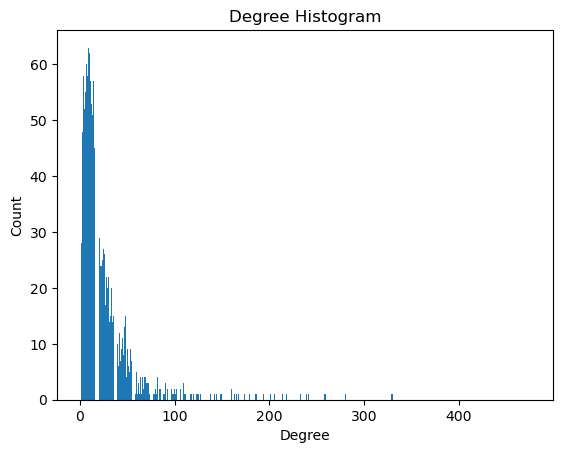

In [66]:
import collections
import matplotlib.pyplot as plt

degree_sequence = sorted(
    [d for n, d in G_superhero.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
degree, count = zip(*degreeCount.items())

plt.bar(degree, count)

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

plt.show()


In [33]:
print(f'number of isolated nodes {len(list(nx.isolates(G_superhero)))}')


number of isolated nodes 34


In [34]:
G_superhero.remove_nodes_from(list(nx.isolates(G_superhero)))
print(f'number of isolated nodes {len(list(nx.isolates(G_superhero)))}')


number of isolated nodes 0


In [35]:
# Sanity check
degree_dict = dict(G_superhero.degree)

for k, v in degree_dict.items():
    # Are there any nodes with 0 connections?
    if v == 0:
        print("0 connections:", k, v)
    # What are the most connected nodes?
    if v > 150:
        print(k, "has a total of", v, "connections")


Superman has a total of 237 connections
Lex Luthor has a total of 164 connections
Batman has a total of 244 connections
Wonder Woman has a total of 156 connections
Spider-Man has a total of 480 connections
Doctor Doom has a total of 258 connections
Thor (Marvel Comics) has a total of 283 connections
Punisher has a total of 167 connections
Captain America has a total of 439 connections
Luke Cage has a total of 182 connections
Daredevil (Marvel Comics character) has a total of 215 connections
Hulk has a total of 336 connections
Doctor Strange has a total of 244 connections
Iron Man has a total of 420 connections
Nick Fury has a total of 221 connections
Thanos has a total of 161 connections
Deadpool has a total of 166 connections
Wolverine (character) has a total of 330 connections
Professor X has a total of 172 connections
Hawkeye (Clint Barton) has a total of 202 connections
Scarlet Witch has a total of 187 connections
Red Skull has a total of 162 connections
Norman Osborn has a total o

## Simple network statistics and analysis

What is the number of nodes in the network?
More importantly, what is the number of links? (Chat with a fellow student or a TA to make sure you're in the right ball-park)
What is the number of links connecting Marvel and DC? What do those links mean?

In [36]:
print('Total number of nodes: ', len(G_superhero.nodes()))
print('Total number of edges: ', G_superhero.number_of_edges())


Total number of nodes:  1599
Total number of edges:  21934


In [37]:
# links connecting Marvel and DC

DC_marvel_links = 0

# Funny coincidence where a node has been created without actually being on the csv list / Red Tornado (identity) exist as
# a seperate page https://en.wikipedia.org/w/index.php?title=Red_Tornado_(identity)&redirect=no and something something
# end result, i will manually assign universe

for char in G_superhero.nodes:
    # check if universe of outgoing links (neighbors) are different
    neigh_list = [n for n in G_superhero.neighbors(char)]
    for neigh in neigh_list:
        if G_superhero.nodes[char]['universe'] != G_superhero.nodes[neigh]['universe']:
            DC_marvel_links += 1

print(
    f'Total connections between marvel and DC characters (directional): {DC_marvel_links}')


Total connections between marvel and DC characters (directional): 242


Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?
Compare the out-degree distribution to a random network with the same number of nodes and links.
Compare the in-degree distribution to a scale-free network with the same number of nodes.

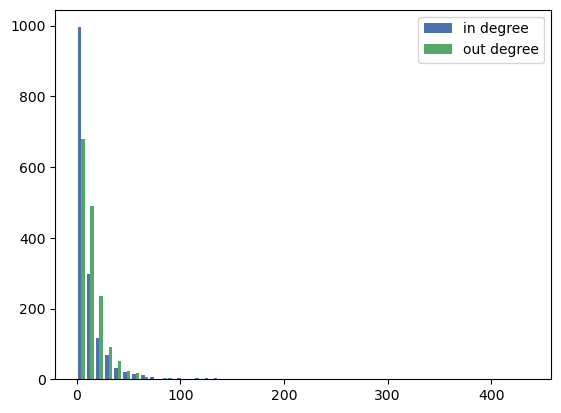

In [38]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

in_super = sorted([d for n, d in G_superhero.in_degree()], reverse=True)
out_super = sorted([d for n, d in G_superhero.out_degree()], reverse=True)

plt.hist([in_super, out_super], bins=50, label=['in degree', 'out degree'])
plt.legend(loc='upper right')
plt.show()


In total the number of in and out degrees must be equal to one another, but there is a higher proportion of nodes with a low in degree, than there are nodes with a low out-degree. It means that it is more common for nodes to have just a few in-connections, and more common to have more out-connections.

This is possible due to a few nodes that have a lot of in-wards links, central hubs like Spiderman, Batman etc. where a lot of other characters link to, but these hubs link less outwards.  

Compare the out-degree distribution to a random network with the same number of nodes and links.
Compare the in-degree distribution to a scale-free network with the same number of nodes.

### Task: Let's generate the Random (Erdös-Renyi) network which has a degree distribution that matches the SuperHero network

Knowing the values of $N$ and number of edges we can calculate $k$, and then $p$, the probability of edge creation. 

Given the equation for a ER network &lt;$k$&gt; = $p(N - 1)$, where $p = k / (N - 1)$. which gives us $p = 0.002$.


In [39]:
# Average degree dist of Superhero

N_super = len(G_superhero.nodes())
k_super = G_superhero.number_of_edges()/N_super

p_random = k_super/(N_super-1)
print(p_random)


0.00858405715086322


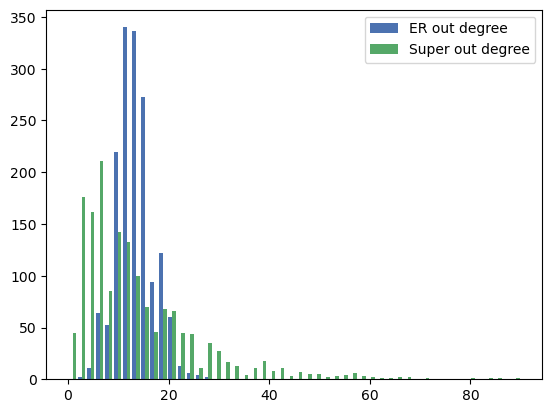

Total outgoing in ER: 21356
Total outgoing in Super Graph: 21934


In [40]:
G1 = nx.erdos_renyi_graph(N_super, p_random)

out_ER = sorted([d for n, d in G1.degree()], reverse=True)

plt.hist([out_ER, out_super], bins=50, label=[
         'ER out degree', 'Super out degree'])
plt.legend(loc='upper right')

plt.show()

# Sanity check
print('Total outgoing in ER:', sum(out_ER))
print('Total outgoing in Super Graph:', sum(out_super))


In [41]:
import math
math.log(N_super)


7.377133712833954

In [1]:
def select_the_best_marvel_charachter(G):
    # select the best character based on the number of connections
    # return the name of the character and the number of connections
    degree_dict = dict(G.degree)
    max_degree = max(degree_dict.values())
    for k, v in degree_dict.items():
        if v == max_degree:
            return k, v


print(select_the_best_marvel_charachter(G_superhero))


def select_the_most_lame_marvel_character(G):
    # select the most lame character based on the number of connections
    # return the name of the character and the number of connections
    degree_dict = dict(G.degree)
    min_degree = min(degree_dict.values())
    for k, v in degree_dict.items():
        if v == min_degree:
            return k, v


print(select_the_most_lame_marvel_character(G_superhero))


def solve_the_assignment_meant_to_be_solved_in_this_notebook(G):
    degree_dict = dict(G.degree)
    for k, v in degree_dict.items():
        if k == 'Thor':
            return k, v


print(solve_the_assignment_meant_to_be_solved_in_this_notebook(G_superhero))


def select_jespers_favorite_superhero(G):
    degree_dict = dict(G.degree)
    for k, v in degree_dict.items():
        if k == 'Batman':
            return k, v


print(select_jespers_favorite_superhero(G_superhero))


def identify_subcommunities(G):
    # identify the subcommunities in the network
    # return the number of subcommunities
    return nx.number_connected_components(G)


def idenityf_subcommunities_in_the_dc_universe(G):
    # identify the subcommunities in the DC universe
    # return the number of subcommunities
    G_DC = G.subgraph([n for n in G.nodes if G.nodes[n]['universe'] == 'DC'])
    return nx.number_connected_components(G_DC)


NameError: name 'G_superhero' is not defined


We see that $<k> = 11.9$ which means that the network is in the **fully connected regime**, since $<k>     > lnN$:


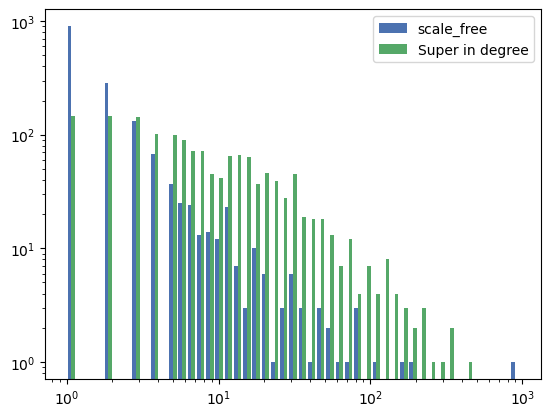

Average degree:  2.1982489055659786


In [43]:
G2 = nx.scale_free_graph(N_super)

# As the scalefree is unidirectional there is no such thing as in our out
degree_scalefree = sorted([d for n, d in G2.degree()], reverse=True)

plt.hist([degree_scalefree, in_super],
         bins=np.logspace(np.log10(min(degree_scalefree)),
                          np.log10(max(degree_scalefree)), 50),
         label=['scale_free', 'Super in degree'])
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')

plt.show()

N_scale = len(G2.nodes())
k_scale = G2.number_of_edges()/N_super
# Expected to be >2
print('Average degree: ', k_scale)


A scale-free network is a network whose degree distribution follows a power law. Hence it should form a linear line when plotted on a log-scale (ish). It seems that the super hero in degree follows that pattern well along with the scale-free.

## Hmm was there something about the binning of log histograms that scewed the data... Review of last histogram log assignement?

# Week 5
## Part A

### Exercise 1:
Use NetworkX DiGraph to store the network of characters. Remember that characters are linked if they have a corresponding link between their Wikipedia pages.
- Additionally, extract the largest component - it will make our work with visualisations much easier 
- As you build the graph, store the attributes of the nodes (remember the universe from the past week). On top of that, let's also store the length of the content as one of the attributes of the node (i.e. count the number of words you have in each character's page

In [44]:
superhero_subgraphs = [G_superhero.subgraph(
    c).copy() for c in nx.weakly_connected_components(G_superhero)]
GC_superhero = max(superhero_subgraphs, key=len)

print(f"Total chars in largest component: { len(GC_superhero.nodes()) }")

charcheck = 'Batman'
print(
    f"Check for {charcheck} attributes: len of text {GC_superhero.nodes[charcheck]['textlen']} and universe: {GC_superhero.nodes[charcheck]['universe']}")


Total chars in largest component: 1597
Check for Batman attributes: len of text 31914 and universe: dc


### Exercise 2: Let's build a simple visualization of network

In [45]:
GC_super_un = GC_superhero.to_undirected()


In [46]:
pos = nx.kamada_kawai_layout(GC_super_un)


In [47]:
universe_color = []
for char in GC_super_un.nodes():
    if GC_super_un.nodes[char]['universe'] == 'dc':
        universe_color.append('#034078')
    elif GC_super_un.nodes[char]['universe'] == 'marvel':
        universe_color.append('#ff206e')

degree_list = []
for char in GC_super_un.nodes():
    degree_list.append(GC_super_un.degree(char))

# normalize node size to highest degree with max size = 30
max_degree = max(degree_list)
node_size_list = [x/max_degree*200 for x in degree_list]


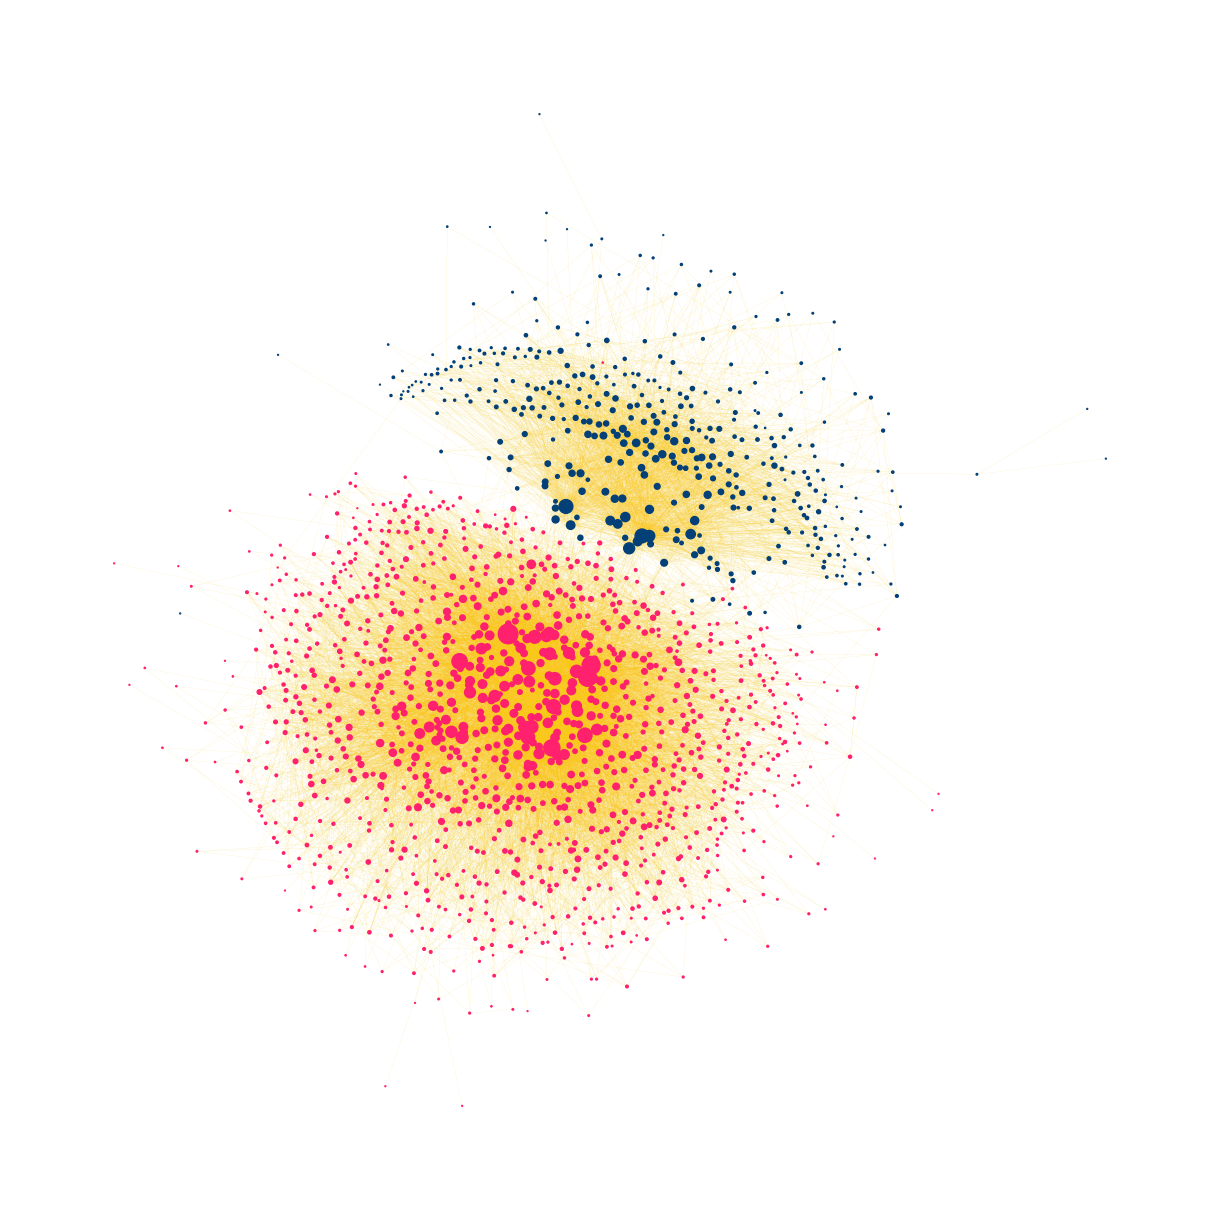

In [48]:
plt.figure(figsize=(12, 12))
nx.draw(GC_super_un, pos=pos, with_labels=False, node_size=node_size_list,
        width=0.05, node_color=universe_color, edge_color='#f9c80e')


## Exercise 3

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 31.84it/s]


BarnesHut Approximation  took  3.03  seconds
Repulsion forces  took  11.97  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


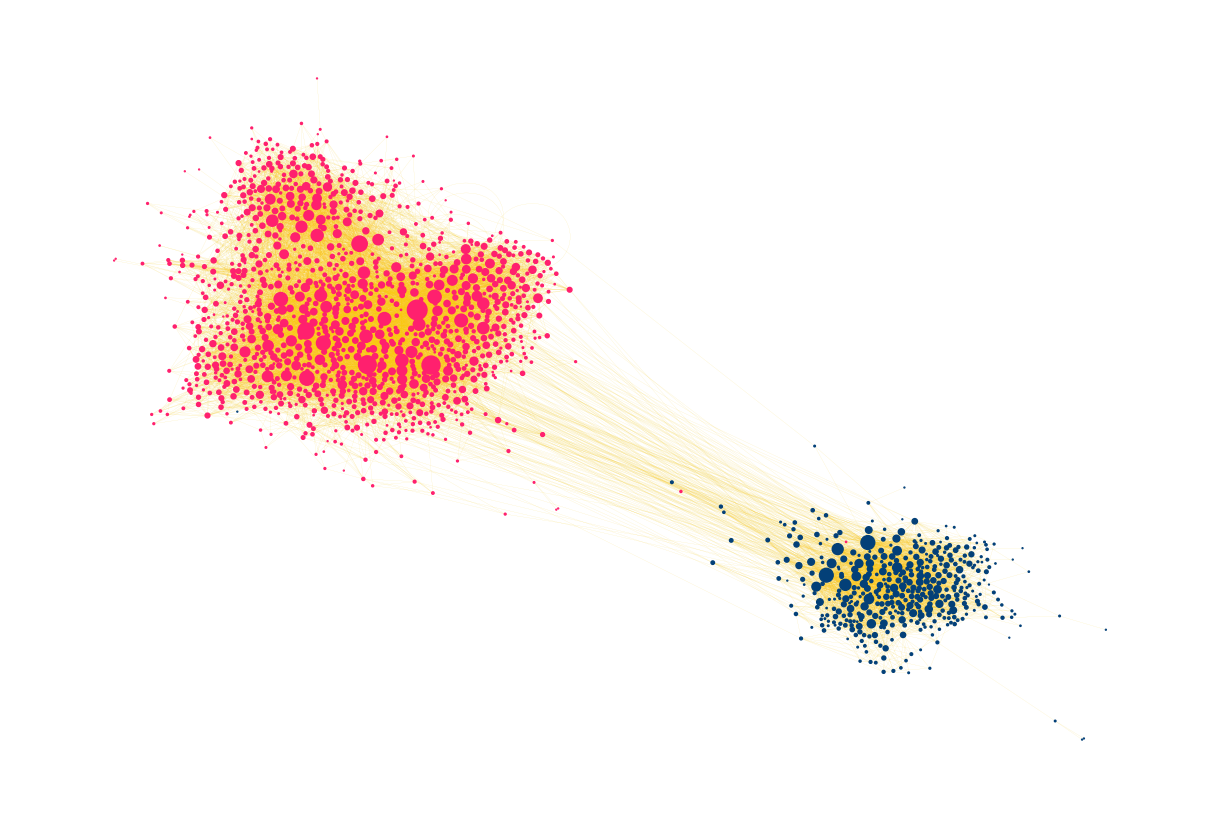

In [49]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(
    GC_super_un, pos=None, iterations=500)

plt.figure(figsize=(12, 8))
nx.draw(GC_super_un, pos=positions, with_labels=False, node_size=node_size_list,
        width=0.05, node_color=universe_color, edge_color='#f9c80e')


Describe the structure you observe. Can you see that the nodes seperate into two separate clusters? Can you see high-degree nodes? In the plot, the red nodes seem to split into two sub-clusters: What's going on there

The split within the marvel universe (red) indicate that there are two 'sub-groupings'. A theory could for example be that there exist a lot of links between avenger characters, originally Iron Man, Captain America, Thor, Hulk, Black Widow and Hawkeye (both movie and comics), and that in a somewhat seperate community the most connected character, Spider-man, has some groupings of his own. Untill 2015 the movie rights for Spiderman was solely Sony's and therefor Spiderman did not appear in any avenger/marvel movies, potentieally limiting the amount of links to other marvel movie characters historically speaking. It could also be that it is another sub-community of super heroes..

## Exercise 4
- Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
- Consider the set of neighbours pointing towards the node found above.
- What is the relation between the characters you identified and their network neighbours? (e.g. do they appear in the same comics?, are they opponents?, etc ...). You don't need to come up with a grand theory of comics here, I just want you to think about how links arise, why the links are there.
- Repeat the exercise for the largest out-degree node.
- Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia
- Are there any nodes with high out-degree and with few incoming connections? If yes, open WikiPages of such characters and explain what happens?
- Are there any nodes with high in-degree and few outcoming connections? Again, open WikiPages of such characters and explain what happens?

In [50]:
sorted(GC_superhero.in_degree, key=lambda x: x[1], reverse=True)[:10]


[('Spider-Man', 437),
 ('Captain America', 353),
 ('Iron Man', 330),
 ('Hulk', 293),
 ('Wolverine (character)', 250),
 ('Thor (Marvel Comics)', 227),
 ('Batman', 216),
 ('Superman', 215),
 ('Doctor Strange', 197),
 ('Doctor Doom', 196)]

The highest in-degree node is Spider-man

In [51]:
connect_to_spider = list(GC_superhero.predecessors('Spider-Man'))
print(connect_to_spider[:15])

universe_count = {'dc': 0, 'marvel': 0}
for char in connect_to_spider:
    if GC_superhero.nodes[char]['universe'] == 'dc':
        universe_count['dc'] += 1
    else:
        universe_count['marvel'] += 1

print(universe_count)


['Superman', 'Batman', 'Doctor Fate', 'Super-Adaptoid', 'Ambush Bug', 'Doctor Doom', 'Absorbing Man', 'Blue Devil (DC Comics)', 'Black Orchid (character)', 'Punisher', 'Moon Knight', 'Attuma', 'Lois Lane', 'Captain America', 'Luke Cage']
{'dc': 8, 'marvel': 429}


With 429 in-nodes it is quite difficult to come up with a general description of what 'relation' the neighbors to Spider-man has, however, it can be seen that clearly that majority of in-links are coming from other marvel characters (429 vs 8). It is also clear that all top 10 nodes in terms of in-link are main characters and all but Doctor Doom are somewhat "good guys", the heroes & central characters. It makes sense that the most in-linked characters are those that by common intution is the most popular, as most pages even less known superheroes&villains will with a higher probability link to the main protagonist.

In [52]:
connect_to_batman = list(GC_superhero.predecessors('Batman'))
print(connect_to_batman[:15])

universe_count = {'dc': 0, 'marvel': 0}
for char in connect_to_batman:
    if GC_superhero.nodes[char]['universe'] == 'dc':
        universe_count['dc'] += 1
    else:
        universe_count['marvel'] += 1

print(universe_count)


['Green Lantern', 'Martian Manhunter', 'Superman', 'Nekron', 'Lex Luthor', 'Abra Kadabra (character)', 'Wally West', 'Captain Cold', 'Weather Wizard', 'Doctor Manhattan', 'Zatanna', 'Doctor Fate', 'Abby Holland', 'Floronic Man', 'Etrigan the Demon']
{'dc': 197, 'marvel': 19}


The same pattern seem to be true for the second most in-linked character, Batman

- Repeat the exercise for the largest out-degree node.
- Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia

In [53]:
sorted(GC_superhero.out_degree, key=lambda x: x[1], reverse=True)[:10]


[('Iron Man', 90),
 ('Captain America', 86),
 ('Norman Osborn', 83),
 ('Wolverine (character)', 80),
 ('Kraven the Hunter', 71),
 ('Betsy Braddock', 68),
 ('Doctor Octopus', 67),
 ('Cyclops (Marvel Comics)', 66),
 ('Spider-Ham', 66),
 ('Hawkeye (Clint Barton)', 64)]

In [54]:
connect_from_ironman = list(GC_superhero.successors('Spider-Man'))
print(connect_from_ironman[:40])

universe_count = {'dc': 0, 'marvel': 0}
for char in connect_from_ironman:
    if GC_superhero.nodes[char]['universe'] == 'dc':
        universe_count['dc'] += 1
    else:
        universe_count['marvel'] += 1

print(universe_count)


['Black Cat (Marvel Comics)', 'Silk (comics)', 'Gwen Stacy', 'Iron Man', 'Ricochet (comics)', 'Dusk (comics)', 'Hornet (comics)', 'Ben Reilly', 'Scarlet Spider', 'Captain Universe', 'Uncle Ben', 'Richard and Mary Parker', 'Flash Thompson', 'J. Jonah Jameson', 'Harry Osborn', 'Mary Jane Watson', 'Doctor Octopus', 'Green Goblin', 'Bucky Barnes', 'Captain America', 'Batman', 'Spider-Man 2099', 'Hawkman', 'Hulk', 'George Stacy', 'Superman', 'Ezekiel (comics)', 'Loki (Marvel Comics)', 'Sandman (Marvel Comics)', 'Electro (Marvel Comics)', 'Mysterio', 'Norman Osborn', 'Kraven the Hunter', 'Scorpion (Marvel Comics)', 'Morbius, the Living Vampire', 'Hobgoblin (comics)', 'Roderick Kingsley', 'Carnage (character)', 'Liz Allan', 'Betty Brant']
{'dc': 3, 'marvel': 40}


Aside from the top-2 outlink chars (ironman & captain america) the top10 outlink characters contain more villains (Norman Osborn, Kraven the Hunter, Doctor Octopus) and side-characters (cyclops, Betsy braddock, spider-ham) than the top10 in-link chars. It appears that wikipages of villians or side character have relatively more outwards references than their super-hero counterwarts. Generally links that point outwards from a wikipedia page is created when external 'knowledge' is needed to explain a concept, one hypoythesis could be that the core content of many main protagonists are explained by their "own" story where it is less relevant to link to external characters, whereas villains and sidekicks only exist by nature of their connection to other characters. The story of villains and sidekicks is more about their role in relation to other characters, hence they have a bigger need to use outlinks for referencing.

#### Questions
- Are there any nodes with high out-degree and with few incoming connections? If yes, open WikiPages of such characters and explain what happens?
- Are there any nodes with high in-degree and few outcoming connections? Again, open WikiPages of such characters and explain what happens?

Checking by inspecting the difference between out-in nodes, must mean they have a high out degree and a relatively low in

In [55]:
out_dict = dict(GC_superhero.out_degree)
in_dict = dict(GC_superhero.in_degree)

out_dict_dif = {key: out_dict[key] - in_dict.get(key, 0)
                for key in out_dict.keys()}

sorted(out_dict_dif.items(), key=lambda x: x[1], reverse=True)[:10]


[('K', 45),
 ('Spider-Ham', 39),
 ('Eclipso#Alex Montez', 38),
 ('Karla Sofen', 37),
 ('Bishop (Marvel Comics)', 33),
 ("Jack O'Lantern (Marvel Comics)", 29),
 ('Abomination (character)', 28),
 ('Cyborg (DC Comics)', 26),
 ('Atom (character)', 26),
 ('list of Eternals', 26)]

In [56]:
in_dict_dif = {key: in_dict[key] - out_dict.get(key, 0)
               for key in in_dict.keys()}

sorted(in_dict_dif.items(), key=lambda x: x[1], reverse=True)[:10]


[('Spider-Man', 394),
 ('Captain America', 267),
 ('Hulk', 250),
 ('Iron Man', 240),
 ('Superman', 193),
 ('Batman', 188),
 ('Thor (Marvel Comics)', 171),
 ('Wolverine (character)', 170),
 ('Doctor Strange', 150),
 ('Doctor Doom', 134)]

In [917]:
df_superhero.loc[df_superhero['CharacterName'] == 'K']


,Unnamed: 0,CharacterName,WikiLink,file,universe,WikiOutLinks,TextLen


Cant spend more time on this...

# Part B
What are the average, median, mode, minimum and maximum value of the in-degree?

SKIPPING THIS TO SAVE TIME

## Centralities, assortativity and more

1) Find the 5 most central characters according to degree centrality.
Repeat Exercise 2 or 3 from part A above for your new sub-network (depending on which visualization method you liked the most), but with our new network.

In [62]:
# Build a strictly marvel based network..

G_marvel = G_superhero.copy()
DC_to_remove = [node for node in G_marvel.nodes(
) if G_marvel.nodes[node]['universe'] == 'dc']
G_marvel.remove_nodes_from(DC_to_remove)
G_marvel.remove_nodes_from(list(nx.isolates(G_marvel)))


In [65]:
print('Total number of nodes: ', len(G_marvel.nodes()))
print('Total number of edges: ', G_marvel.number_of_edges())


Total number of nodes:  1193
Total number of edges:  17579


In [71]:
centrality_dict = nx.degree_centrality(G_marvel)
print('5 characters with highest centrality in the marvel universe')
sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:5]


5 characters with highest centrality in the marvel universe


[('Spider-Man', 0.3934563758389262),
 ('Captain America', 0.3548657718120805),
 ('Iron Man', 0.3464765100671141),
 ('Hulk', 0.27936241610738255),
 ('Wolverine (character)', 0.27432885906040266)]

In [75]:
G_marvel_un = G_marvel.to_undirected()

universe_color = []
for char in G_marvel_un.nodes():
    if G_marvel_un.nodes[char]['universe'] == 'dc':
        universe_color.append('#034078')
    elif G_marvel_un.nodes[char]['universe'] == 'marvel':
        universe_color.append('#ff206e')

degree_list = []
for char in G_marvel_un.nodes():
    degree_list.append(G_marvel_un.degree(char))

# normalize node size to highest degree with max size = 30
max_degree = max(degree_list)
node_size_list = [x/max_degree*200 for x in degree_list]


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.89it/s]


BarnesHut Approximation  took  1.94  seconds
Repulsion forces  took  8.93  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.11  seconds
AdjustSpeedAndApplyForces step  took  0.22  seconds


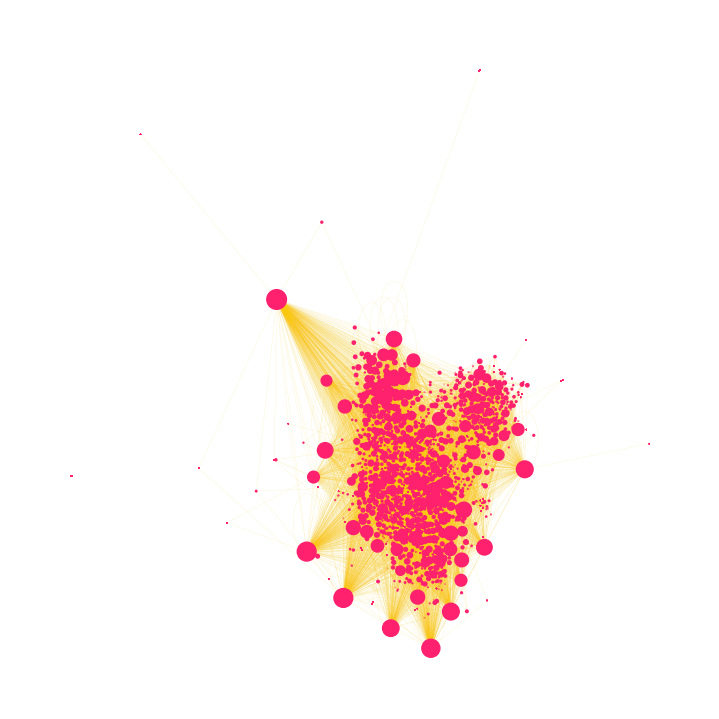

In [101]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=10,
                        strongGravityMode=True,
                        gravity=2,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(
    G_marvel_un, pos=None, iterations=500)

plt.figure(figsize=(7, 7))
nx.draw(G_marvel_un, pos=positions, with_labels=False, node_size=node_size_list,
        width=0.05, node_color=universe_color, edge_color='#f9c80e')


In [83]:
pos = nx.kamada_kawai_layout(G_marvel_un)


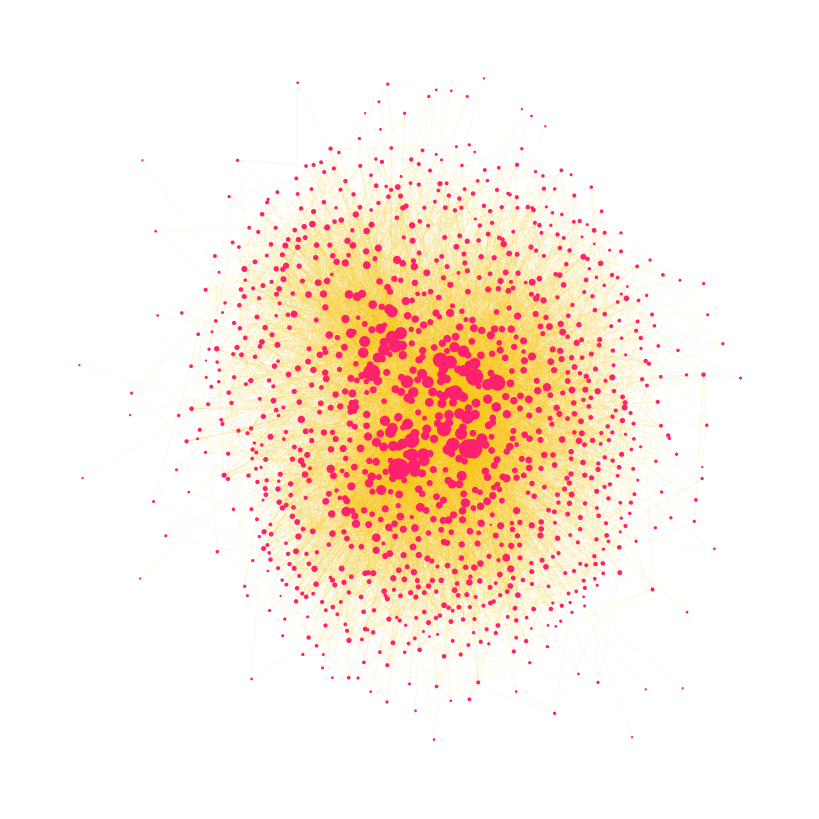

In [85]:
plt.figure(figsize=(8, 8))
nx.draw(G_marvel_un, pos=pos, with_labels=False, node_size=node_size_list,
        width=0.05, node_color=universe_color, edge_color='#f9c80e')



#### 2: What role do you imagine characters with high wikipedia graph betweenness centrality play in the network?

In [91]:
bcentrality_dict = nx.betweenness_centrality(G_marvel)
print('5 characters with highest betweeness centrality in the marvel universe')
sorted(bcentrality_dict .items(), key=lambda x: x[1], reverse=True)[:5]


5 characters with highest betweeness centrality in the marvel universe


[('Captain America', 0.06888442669758255),
 ('Iron Man', 0.0671632378612684),
 ('Wolverine (character)', 0.059968059955337404),
 ('Spider-Man', 0.04292284437789209),
 ('Hulk', 0.036061588486670446)]

In [95]:
bcentrality = []
for node in G_marvel_un.nodes():
    bcentrality.append(bcentrality_dict[node])

# normalize node size to highest centrality with max size = 30
max_bcentrality = max(bcentrality)
node_size_list = [x/max_bcentrality*200 for x in bcentrality]


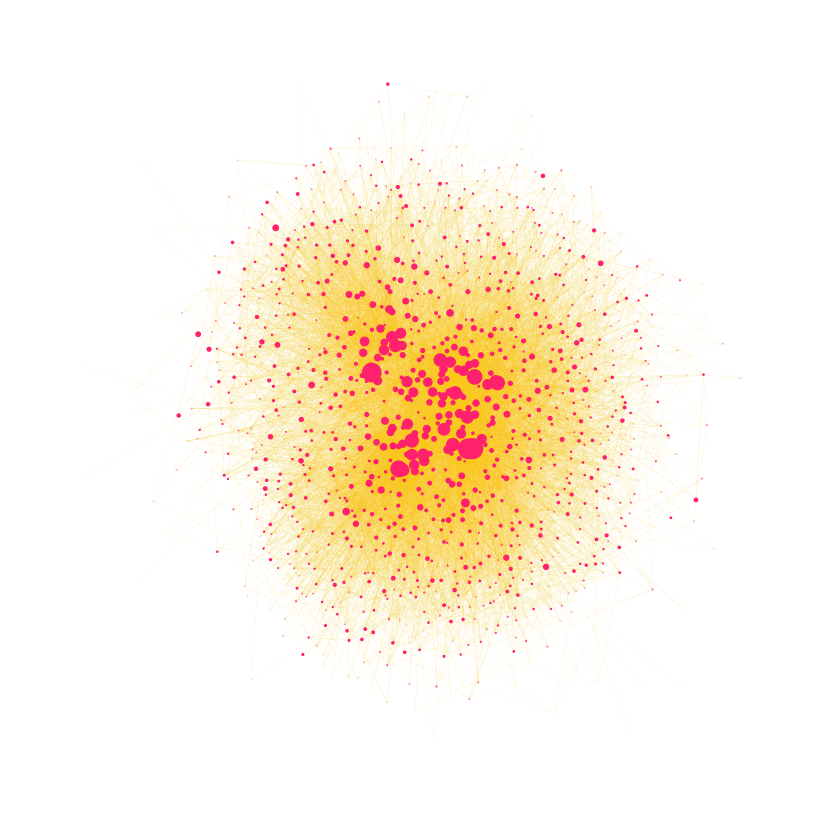

In [96]:
plt.figure(figsize=(8, 8))
nx.draw(G_marvel_un, pos=pos, with_labels=False, node_size=node_size_list,
        width=0.05, node_color=universe_color, edge_color='#f9c80e')


#### 3: Eigenvector centrality

In [99]:
ecentrality_dict = nx.eigenvector_centrality(G_marvel)
print('5 characters with highest betweeness centrality in the marvel universe')
sorted(ecentrality_dict .items(), key=lambda x: x[1], reverse=True)[:5]


5 characters with highest betweeness centrality in the marvel universe


[('Spider-Man', 0.2681433632156157),
 ('Iron Man', 0.24637961599066321),
 ('Captain America', 0.24573299037015314),
 ('Hulk', 0.22573467130517388),
 ('Wolverine (character)', 0.1928670705477368)]

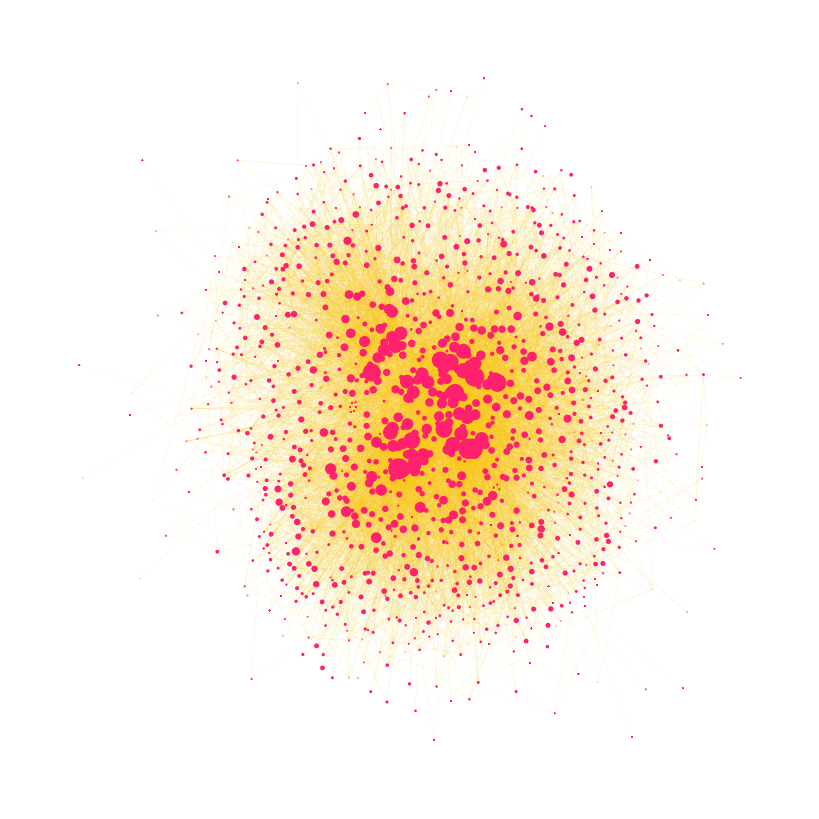

In [100]:
ecentrality = []
for node in G_marvel_un.nodes():
    ecentrality.append(ecentrality_dict[node])

# normalize node size to highest centrality with max size = 30
max_ecentrality = max(ecentrality)
node_size_list = [x/max_ecentrality*200 for x in ecentrality]

plt.figure(figsize=(8, 8))
nx.draw(G_marvel_un, pos=pos, with_labels=False, node_size=node_size_list,
        width=0.05, node_color=universe_color, edge_color='#f9c80e')


#### 4: Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why?


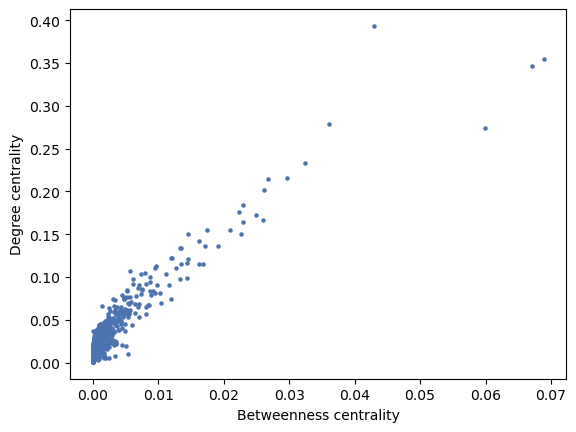

In [116]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')


plt.scatter(list(bcentrality_dict.values()),
            list(centrality_dict.values()), s=5)
# plt.xlim(0,max(list(centrality_dict.values()))*1.2)
# plt.ylim(0,max(list(centrality_dict.values()))*1.2)
plt.xlabel('Betweenness centrality')
plt.ylabel('Degree centrality')

plt.show()


Yes there is a strong correlation. High betweenness centrality means that a high number of shortest paths from any node, to another node, go through that given node. Hence if one is to connect to any other random node in the network, chances are that you will go through a node with a high betweeness centrality. It makes sense, that this overlaps with nodes that have a high degree centrality that is simply a normalized version of the degree, i.e. a node with high degree centrality has relatively high number of degrees in the network, and is therefor also likely to be a central link in shortest paths from A-Z.


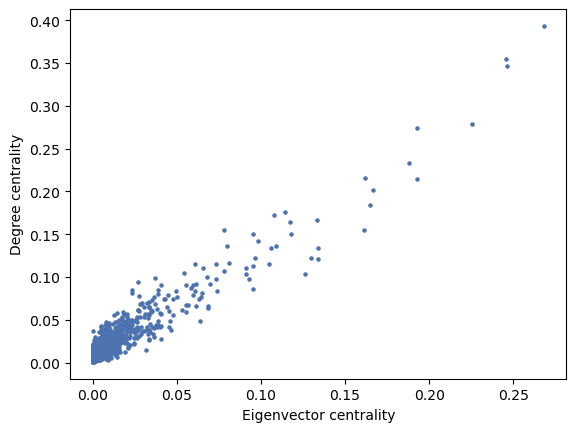

In [118]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')


plt.scatter(list(ecentrality_dict.values()),
            list(centrality_dict.values()), s=5)
# plt.xlim(0,max(list(centrality_dict.values()))*1.2)
# plt.ylim(0,max(list(centrality_dict.values()))*1.2)
plt.xlabel('Eigenvector centrality')
plt.ylabel('Degree centrality')

plt.show()


#### 4b: Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?

At the degree centr vs betweenness centr there are a few 'outliers' that have an extremely high betweenness centrality, likely the central hubs of the giant components. These are not clear in the degree vs eigenvector centrality, because the Eigenvector centrality is an average of all the neighbors and therefor a few outliers will likely get "more averaged".

#### 5: Is the undirected version of the graph assortative with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.

"Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors."
Hence from the plot above, eigenvector centrality vs degree centrality, we can conclude that high degree nodes (high y value) link to oher high degree characters (eigenvector centrality score, x-axis)

In [128]:
G_marvel_uni = G_marvel.to_undirected()
nx.degree_assortativity_coefficient(G_marvel_uni)


-0.12268198735432552

#### 6: Is the undirected version of the graph assortative with respect do the content length nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and vice versa?. Hint: Use this function. Provide an interpretation of your answer.

In [123]:
assort_textlen = nx.attribute_assortativity_coefficient(G_marvel, 'textlen')
print('Assortativity in respect to the length of wiki texts: ', assort_textlen)


Assortativity in respect to the length of wiki texts:  -0.0005406546023601562
